In [3]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.featurizer import AtomPairsFeaturizer
from msmbuilder.featurizer import ContactFeaturizer
from msmbuilder.cluster import KMedoids
from pyemma.coordinates import tica

import pyemma

pyemma.config.show_progress_bars = False


/Applications/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
import sys
sys.path.insert(0, '/Users/Bren/Documents/Github/observable-tica/tica-class')

from class_obs_tica import ObservableTicaObject
from class_plots import plot_all
from class_plots import plot_3d
from class_plots import plot_all_obs_cmap

In [5]:
def get_adj_list(topology):
    table, bonds = topology.to_dataframe()
        
    neighbors = {}
    for bond in bonds:
        try:
            neighbors[bond[0]].append(bond[1])
        except:
            neighbors[bond[0]] = [bond[1]]
        try:
            neighbors[bond[1]].append(bond[0])
        except:
            neighbors[bond[1]] = [bond[0]]
    return neighbors

In [6]:
def recurse(quad, rtn, adj_list, visited):
    visited[quad[-1]] = True
    if len(quad) == 4:
        return quad
    if len(quad)< 4:
        neigh = adj_list[quad[-1]]
        for n in neigh:
            visited_copy = visited[:]
            quad_copy = quad[:]
            if visited[n]== False:
                visited[n] == True
                quad_copy.append(n)
                a = (recurse(quad_copy, rtn, adj_list, visited))
                if a is not None:
                    rtn.append(a)

## loading and prepping data for alanine dipeptide

In [7]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories

AD_top = trajs[0].topology

AD_neighbors = get_adj_list(AD_top)

alanine_dipeptide already is cached


In [8]:
AD_torsion_quads = []
for atom in range(AD_top.n_atoms):
    rtn = []
    visited = [False]*AD_top.n_atoms
    recurse([atom], rtn, AD_neighbors, visited)
    AD_torsion_quads.extend(rtn)


In [9]:
for i in AD_torsion_quads:
    i.sort()

In [10]:
AD_torsion_quads = [tuple(l) for l in AD_torsion_quads]
AD_torsion_quads = set(AD_torsion_quads)

print(len(AD_torsion_quads))

41


In [11]:
X1 = [md.compute_dihedrals(traj, AD_torsion_quads) for traj in trajs]


In [12]:
heavy_atom_ind_list = [[j.index for j in i.atoms if j.element.name!="hydrogen"] for i in AD_top.residues]
heavy_atoms = [atom for residue in heavy_atom_ind_list for atom in residue]

In [13]:
frank_atoms = [4,6,8,10,14,16]

all_pairs = []
for i in range(len(frank_atoms)):
    for j in range(i):
        all_pairs.append((frank_atoms[i],frank_atoms[j]))

In [14]:
Y1 = AtomPairsFeaturizer(all_pairs).fit_transform(trajs)

# Alanine Dipeptide Observable tICA
X1 = all torsions including H
<br>
Y1 = interatomic distances of all heavy atoms

X dims:  (10, 9999, 41)
Y dims:  (10, 9999, 45)
Fitting data to object pre-whitening
Whitening Data
Estimating Koopman Matrices
largest eigenval:  1.0
Solving Riccati
(24, 24)
Performing SVD
Done.


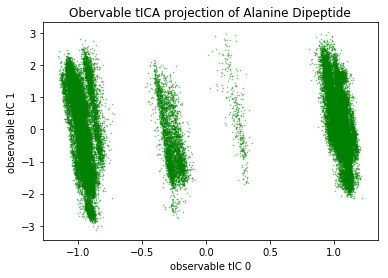

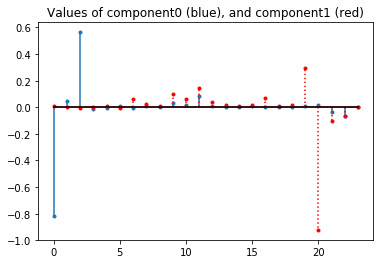

component 1: 
 [ -8.14715097e-01   4.71332892e-02   5.64284351e-01  -1.42058919e-02
  -8.32285511e-03   9.11335544e-03  -4.40692391e-03   1.16643836e-02
   5.79223348e-03   3.24148642e-02   1.79657188e-02   8.40035613e-02
   1.29082313e-02   1.20582775e-04  -9.91747348e-04   8.44766088e-03
   2.21952049e-03   1.25069198e-03   1.39875236e-03   1.21080347e-02
   1.78116701e-02  -3.42891515e-02  -6.88523421e-02   7.28270786e-05]
component 2: 
 [  8.80989500e-03  -1.12204847e-03  -8.70744969e-03  -2.86965982e-04
   8.31040057e-03  -1.99858429e-03   6.46388235e-02   2.18325545e-02
   9.78403496e-03   9.97796363e-02   6.05309031e-02   1.42006344e-01
   3.99631134e-02   1.44432556e-02   1.14524839e-02   1.56559590e-02
   6.99761030e-02   1.09302791e-02   1.45436197e-02   2.98824571e-01
  -9.22060470e-01  -1.00486499e-01  -6.50921580e-02  -3.23817094e-04]
torsion angle corresponding to largest obs component(0) value:
 (14, 15, 16, 17)
torsion angle corresponding to largest obs component(1) val

In [14]:
test1 = ObservableTicaObject()
tics1 = test1.fit_transform(X1,Y1)
table, bonds = AD_top.to_dataframe()


plt.scatter(tics1[:,0], tics1[:,1], c='g', s = .3, alpha = .5)
plt.xlabel('observable tIC 0')
plt.ylabel('observable tIC 1')
# plt.xticks([-2, 0, 2])
# plt.yticks([-3, 0, 3])
plt.title('Obervable tICA projection of Alanine Dipeptide')

fig, ax = plt.subplots()
# FIRST TIC IS BLUE
ax.stem(range(len(test1.u[:,0])), test1.u[:,0], markerfmt='.', basefmt = None)

# SECOND TIC IS RED
ax.stem(range(len(test1.u[:,0])), test1.u[:,1], markerfmt='r.', linefmt ='r:', basefmt='k')
plt.title('Values of component0 (blue), and component1 (red)')
plt.show()


print('component 1: \n', test1.u[:,0])
print('component 2: \n', test1.u[:,1])
print('torsion angle corresponding to largest obs component(0) value:\n', list(AD_torsion_quads)[np.argmax(abs(test1.u[:,0]))])
print('torsion angle corresponding to largest obs component(1) value:\n', list(AD_torsion_quads)[np.argmax(abs(test1.u[:,1]))])

print(table)
# test.u[:,0] test.u[:,1]

# Alanine Dipeptide regular tica:
X1 = all torsions including H

10 (9999, 41)


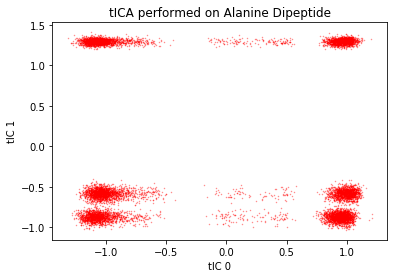

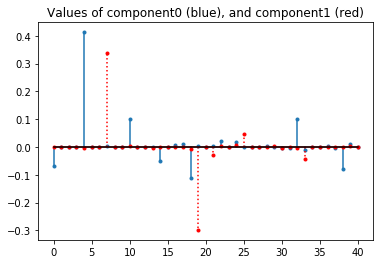

eigenvalue 1:
 0.988851627145
eigenvector 1:
 [ -6.76489715e-02   4.41600941e-04  -8.59229564e-05   1.33521130e-03
   4.12446109e-01   1.68188071e-03   9.91542402e-04   1.84512319e-03
  -1.91541000e-05  -6.13112721e-04   1.02389273e-01   1.74418202e-04
  -5.37621274e-04   8.23362326e-04  -4.90386232e-02   6.92002236e-04
   8.88209569e-03   1.23553204e-02  -1.10169754e-01   4.08388733e-03
   2.26897037e-04   3.08991437e-03   2.10020871e-02  -4.00145544e-05
   1.77848291e-02   1.27979010e-03   1.37683979e-04  -8.58817937e-04
   3.84789562e-03   9.03817826e-04  -2.14570483e-03  -3.21059361e-03
   1.01361060e-01  -9.37979459e-03  -5.88536961e-05   1.37123767e-04
   4.83092934e-03  -3.15527044e-03  -8.08012942e-02   1.23162248e-02
  -6.46309389e-05] 

eigenvalue 2:
 0.980751155591
eigenvector 2:
 [  1.29879768e-04   2.07810497e-04   4.17080745e-04  -1.20200349e-03
  -3.68355540e-03  -3.35282891e-05   1.97203876e-04   3.38868234e-01
  -1.49923086e-04  -1.21347501e-04   2.52615287e-03  -6.253

In [15]:
print(len(X1), X1[0].shape)

obj_AD = tica(X1, lag = 1, dim = 2)
plt.show()
data = np.array(obj_AD.get_output()[0])
plt.scatter(data[:,0], data[:,1], s = .2, alpha = .5, c='r')
plt.xlabel('tIC 0')
plt.ylabel('tIC 1')
# plt.xticks([-2, 0, 2])
# plt.yticks([-3, 0, 3])
plt.title('tICA performed on Alanine Dipeptide')
plt.show()


fig, ax = plt.subplots()
# FIRST TIC IS BLUE
ax.stem(range(len(obj_AD.eigenvectors[:,0])), obj_AD.eigenvectors[:,0], markerfmt='.', basefmt = None)

# SECOND TIC IS RED
ax.stem(range(len(obj_AD.eigenvectors[:,1])), obj_AD.eigenvectors[:,1], markerfmt='r.', linefmt ='r:', basefmt='k')
plt.title('Values of component0 (blue), and component1 (red)')
plt.show()

print('eigenvalue 1:\n', obj_AD.eigenvalues[0])
print('eigenvector 1:\n', obj_AD.eigenvectors[:,0], '\n')
print('eigenvalue 2:\n', obj_AD.eigenvalues[1])
print('eigenvector 2:\n', obj_AD.eigenvectors[:,1], '\n')

# print('all flexible torsions in AD:\n', AD_torsion_quads, '\n')

print('torsion angle corresponding to largest reg component(0) value:\n', list(AD_torsion_quads)[np.argmax(abs(obj_AD.eigenvectors[:,0]))])
print('torsion angle corresponding to largest reg component(1) value:\n', list(AD_torsion_quads)[np.argmax(abs(obj_AD.eigenvectors[:,1]))])

# plt.scatter(X1[0].dot(obj_AD.eigenvectors[:,0]), X1[0].dot(obj_AD.eigenvectors[:,1]),s = .2, alpha = .5, c='r')

# print(bonds)

print(table)